In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

In [36]:
positions = {
    'CBF1': (1.0, 0.0),
    'GAL4': (0.30901699437494745, 0.9510565162951535),
    'GAL80': (-0.8090169943749473, 0.5877852522924732),
    'SWI5': (-0.8090169943749476, -0.587785252292473),
    'ASH1': (0.30901699437494723, -0.9510565162951536)
}

GENE_COLORS = {"SWI5": "blue", "CBF1": "green", "GAL4": "red", "GAL80": "turquoise", "ASH1": "magenta"}

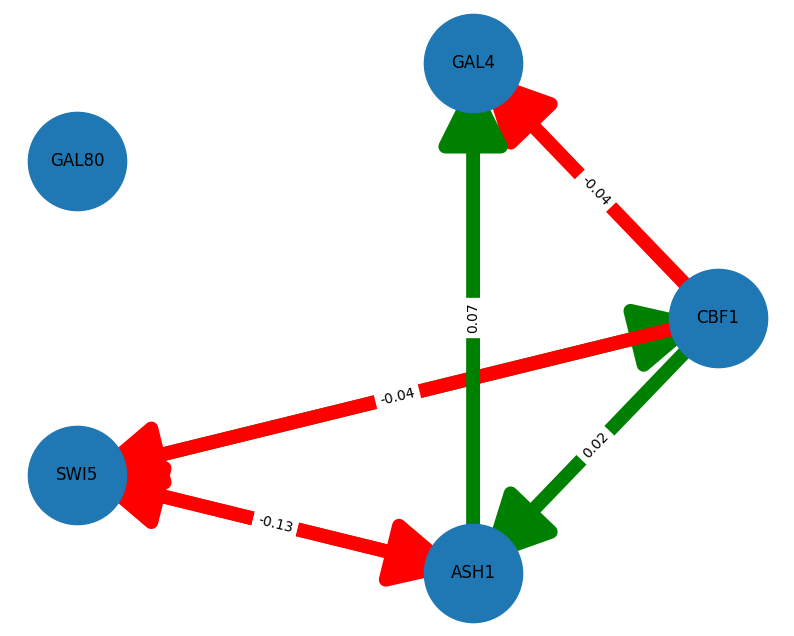

In [59]:

def plot_network(matrix, threshold):
    G = nx.DiGraph()  # Use a Directed Graph

    # Add nodes with the same labels as the correlation matrix columns
    elements = matrix.columns
    G.add_nodes_from(elements)

    # Iterate over the elements to add edges based on the threshold
    for i, element1 in enumerate(elements):
        for j, element2 in enumerate(elements):
            if i == j:
                continue

            edge_value = matrix.iloc[i, j]
            if abs(edge_value) > threshold:  # Check if the correlation meets the threshold
                G.add_edge(element2, element1, weight=edge_value)

    # Create a plot
    plt.figure(figsize=(10, 8))

    # Draw nodes
    nx.draw_networkx_nodes(G, positions, node_size=5000)

    # Extract weights
    weights = np.array(["red" if G[u][v]['weight'] < 0 else "green" for u, v in G.edges()])

    # Draw edges with arrows
    nx.draw_networkx_edges(G, positions, width=10, edge_color=weights, edge_cmap=plt.cm.coolwarm,
                           arrows=True, arrowsize=100)

    # Draw labels for nodes
    nx.draw_networkx_labels(G, positions, font_size=12)

    # Create edge labels for each edge, showing the weight
    edge_labels = dict([((u, v,), f'{d["weight"]:.2f}') for u, v, d in G.edges(data=True)])

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels)

    plt.axis('off')  # Turn off the axis
    plt.show()  # Display the plot


data = {
    'SWI5': [-0.076, 0.033, 0, 0, -0.035],
    'CBF1': [-0.038, 0, -0.041, 0, 0.023],
    'GAL4': [0, 0, 0, 0, 0],
    'GAL80': [0, 0, 0, 0, 0],
    'ASH1': [-0.127, 0, 0.065, 0, 0]
}

# Creating the DataFrame
matrix = pd.DataFrame(data, index=['SWI5', 'CBF1', 'GAL4', 'GAL80', 'ASH1'])

plot_network(matrix, 0.0)

In [75]:
def calculate_confusion_matrix_from_model(model_predicted: dict[str, list[float]],
                                          compare_aginst_switch_off_sereies: bool = True,
                                          consider_inhibition: bool = True,
                                          undirected_model: bool = False) -> pd.DataFrame:
    """
    
    """
    model_switch_off_series = {
        'SWI5': [None, 0, -1, 0, -1],
        'CBF1': [0, None, 0, 0, 0],
        'GAL4': [1, 1, None, 1, 0],
        'GAL80': [0, 0, 0, None, 0],
        'ASH1': [0, 0, 0, 0, None]
    }

    model_true_model = {
        'SWI5': [None, 1, 0, 1, 1],
        'CBF1': [0, None, 1, 0, 0],
        'GAL4': [1, 0, None, -0.5, 0],
        'GAL80': [0, 0, -0.5, None, 0],
        'ASH1': [0, -1, 0, 0, None]
    }

    undirected_model_switch_off_series = {
        'SWI5': [None, 0, 1, 0, 1],
        'CBF1': [0, None, 1, 0, 0],
        'GAL4': [1, 1, None, 1, 0],
        'GAL80': [0, 0, 1, None, 0],
        'ASH1': [1, 0, 0, 0, None]
    }

    undirected_model_true_model = {
        'SWI5': [None, 1, 1, 1, 1],
        'CBF1': [1, None, 1, 0, 1],
        'GAL4': [1, 1, None, 1, 0],
        'GAL80': [1, 0, 1, None, 0],
        'ASH1': [1, 1, 0, 0, None]
    }

    if undirected_model:
        model_compare = undirected_model_switch_off_series if compare_aginst_switch_off_sereies else undirected_model_true_model
        # Also undirected models can't differentiate between inhibition or excitement
        consider_inhibition = False
    else:
        model_compare = model_switch_off_series if compare_aginst_switch_off_sereies else model_true_model

    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0

    for variable in model_compare:
        connections_compare = model_compare[variable]
        connections_predicted = model_predicted[variable]

        for comp, pred in zip(connections_compare, connections_predicted):

            if comp is None:
                # We don't know what the model is doing when 
                continue

            elif comp == 0:
                if pred == 0:
                    true_negatives += 1
                else:
                    false_positives += 1

            elif comp < 0:
                if pred < 0:
                    true_positives += 1
                elif pred == 0:
                    false_negatives += 1
                elif pred > 0 and not consider_inhibition:
                    true_positives += 1

            elif comp > 0:
                if pred > 0:
                    true_positives += 1
                elif pred == 0:
                    false_negatives += 1
                elif pred < 0 and not consider_inhibition:
                    true_positives += 1

    fpr: float = false_positives / (false_positives + true_negatives)
    tpr: float = true_positives / (true_positives + false_positives)
    return fpr, tpr


data = {
    'SWI5': [-0.076, 0.033, 0, 0, -0.035],
    'CBF1': [-0.038, 0, -0.041, 0, 0.023],
    'GAL4': [0, 0, 0, 0, 0],
    'GAL80': [0, 0, 0, 0, 0],
    'ASH1': [-0.127, 0, 0.065, 0, 0]
}

data = {
    'SWI5': [0, 1, -1, 0, -1],
    'CBF1': [0, 0, 0, 0, 0],
    'GAL4': [1, 1, 0, 1, 0],
    'GAL80': [0, 0, 0, 0, 0],
    'ASH1': [0, 0, 0, 0, 0]
}

calculate_confusion_matrix_from_model(data)

(0.06666666666666667, 0.8333333333333334)

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0.  0.2 0.2 1. ]
[0.  0.2 1.  1. ]
[ inf 0.8  0.35 0.05]


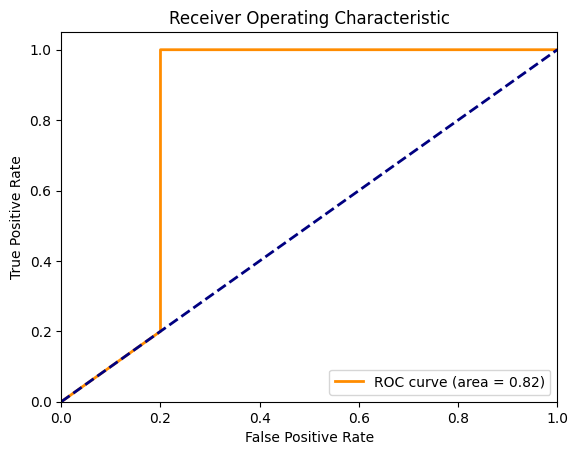

In [1]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Sample data: true binary labels and scores from a classifier
y_true = np.array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0])
y_scores = np.array([0.1, 0.4, 0.35, 0.8, 0.7, 0.2, 0.55, 0.15, 0.8, 0.05])

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(fpr)
print(tpr)
print(thresholds)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
